<a href="https://colab.research.google.com/github/03axdov/Notebooks/blob/main/SentimentClassificationIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 26.9 MB/s 


In [2]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 17.6 MB/s 
     |████████████████████████████████| 99 kB 11.4 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 238 kB 49.2 MB/s 
     |████████████████████████████████| 1.1 MB 60.6 MB/s 
     |████████████████████████████████| 352 kB 50.4 MB/s 
     |████████████████████████████████| 116 kB 71.0 MB/s 
     |████████████████████████████████| 1.3 MB 46.6 MB/s 


In [3]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

In [4]:
URL = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file(
    "aclImdb_v1",
    origin=URL,
    untar=True,
    cache_dir=".",
    cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

84140032/84125825 [==============================] - 4s 0us/step


['imdbEr.txt', 'train', 'README', 'test', 'imdb.vocab']

In [5]:
train_dir = os.path.join(dataset_dir, "train")

os.listdir(train_dir)

['unsupBow.feat',
 'unsup',
 'pos',
 'neg',
 'urls_pos.txt',
 'labeledBow.feat',
 'urls_unsup.txt',
 'urls_neg.txt']

In [6]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    validation_split=0.2,
    subset="training",
    batch_size=BATCH_SIZE,
    seed=seed
)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    validation_split=0.2,
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=seed
)

val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=BATCH_SIZE
)

test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [8]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f"Text: {text_batch[i].numpy().decode()}")
    print(f"Label: {label_batch[i]}")

Text: "Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn't all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that's all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)
Label: 0
Text: David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complica

In [9]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [10]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [11]:
text_test = ["This is an amazing movie with great acting. Definitely recommend it."]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2023  2003  2019  6429  3185  2007  2307  3772  1012  5791 16755]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [13]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.94998425  0.97541046  0.00986121  0.11248696  0.03915322  0.899951
  0.9926104  -0.9968422   0.1921381  -0.9935883   0.15055807 -0.99849254]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.8339977  -0.0392704   0.84244865 ...  0.13409469  0.35958794
   0.4248515 ]
 [-0.47498003 -0.33483204  0.34178516 ...  0.5692081  -0.38512266
   0.9257543 ]
 [-0.6740382   0.32112634 -0.86853504 ...  0.1634635  -0.5651638
   0.50024307]
 ...
 [ 0.9911406   0.02177388 -1.2661084  ...  0.01990693  0.4561287
   0.17067367]
 [ 0.8336479   0.23874828 -0.5371635  ...  0.53630376  1.5761611
   0.5626449 ]
 [-0.09270862 -0.10005929  0.42669985 ...  0.01274664 -0.15042496
   0.4224615 ]]


In [14]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
  preprocessing_inputs = hub.KerasLayer(tfhub_handle_preprocess, name="preprocessing")
  encoder_inputs = preprocessing_inputs(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name="BERT_encoder")
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, name="classifier")(net)
  return tf.keras.Model(inputs=text_input, outputs=net)

In [15]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5133742]], shape=(1, 1), dtype=float32)


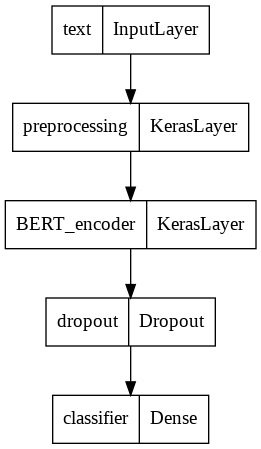

In [16]:
tf.keras.utils.plot_model(classifier_model)

In [17]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.keras.metrics.BinaryAccuracy()

In [18]:
print(tf.data.experimental.cardinality(train_ds).numpy())

625


In [19]:
EPOCHS = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr = init_lr,
    num_train_steps = num_train_steps,
    num_warmup_steps = num_warmup_steps,
    optimizer_type="adamw"
)

In [20]:
classifier_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [21]:
history = classifier_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
625/625 [==============================] - 164s 251ms/step - loss: 0.4954 - binary_accuracy: 0.7351 - val_loss: 0.3890 - val_binary_accuracy: 0.8348
Epoch 2/5
625/625 [==============================] - 168s 268ms/step - loss: 0.3324 - binary_accuracy: 0.8512 - val_loss: 0.3636 - val_binary_accuracy: 0.8422
Epoch 3/5
625/625 [==============================] - 180s 288ms/step - loss: 0.2478 - binary_accuracy: 0.8965 - val_loss: 0.3838 - val_binary_accuracy: 0.8464
Epoch 4/5
625/625 [==============================] - 155s 248ms/step - loss: 0.1930 - binary_accuracy: 0.9240 - val_loss: 0.4338 - val_binary_accuracy: 0.8506
Epoch 5/5
625/625 [==============================] - 155s 247ms/step - loss: 0.1571 - binary_accuracy: 0.9415 - val_loss: 0.4702 - val_binary_accuracy: 0.8486


In [22]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


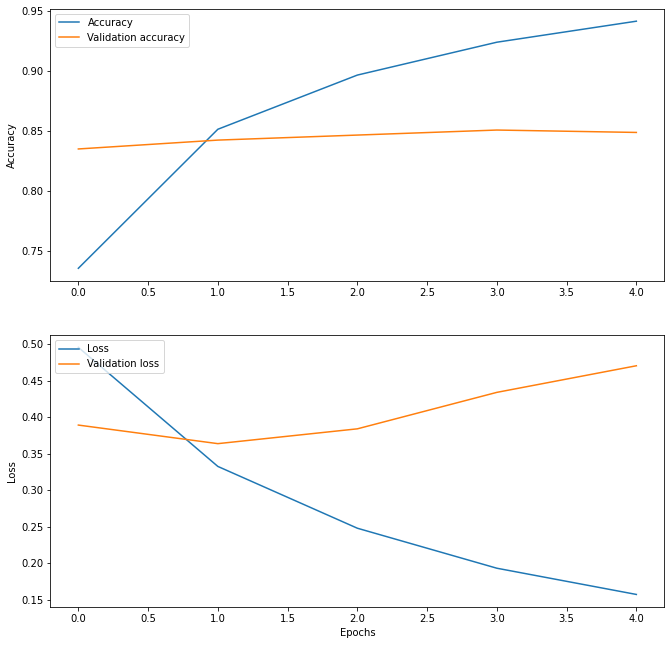

In [23]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(11,11))

plt.subplot(2,1,1)
plt.plot(acc, label="Accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.subplot(2,1,2)
plt.plot(loss, label="Loss")
plt.plot(val_loss, label="Validation loss")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.xlabel("Epochs")

plt.show()

In [24]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 92s 118ms/step - loss: 0.4527 - binary_accuracy: 0.8578
Loss: 0.4527401030063629
Accuracy: 0.8578400015830994


In [25]:
dataset_name = "imdb"
saved_model_path = f'./{dataset_name}'

classifier_model.save(saved_model_path, include_optimizer=False)

In [26]:
reloaded_model = tf.keras.models.load_model(saved_model_path)

In [27]:
reloaded_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [28]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999544
input: The movie was great!           : score: 0.995281
input: The movie was meh.             : score: 0.842396
input: The movie was okish.           : score: 0.011870
input: The movie was terrible...      : score: 0.001235

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999544
input: The movie was great!           : score: 0.995281
input: The movie was meh.             : score: 0.842396
input: The movie was okish.           : score: 0.011870
input: The movie was terrible...      : score: 0.001235

